Self-attention helps a model look at other words in a sentence to better understand the meaning of each word.

Example:

"The animal didn't cross the road because it was too tired."

To understand "it", self-attention lets the model look at other words like "animal" and "road" to figure out what "it" refers to.

In [6]:
import numpy as np

## Matrices Generation
Making Query, Key and Value matrices and naming them capital as standard representation

In [2]:
n, d_k, d_v = 4, 8, 8
Q = np.random.randn(n, d_k)
K = np.random.randn(n, d_k)
V = np.random.randn(n, d_v)

In [3]:
print("Query=",Q)
print("\nKey=",K)
print("\nValue=",V)

Query= [[ 1.33378176  0.74266107  1.00125838 -0.03954034 -0.13385055 -0.66041563
   1.16017292 -0.11053064]
 [ 1.95035643  1.07297649  1.26982626 -1.78016591 -1.49168508 -0.06125613
   1.27077014 -0.15161438]
 [ 0.96509567  0.07978951 -0.17827051  0.26079042  0.48183316  0.20851897
   0.26478907  1.2802874 ]
 [ 1.14182796  0.78241199  1.70333113 -0.10560966 -1.57910727 -0.69745217
   1.7675734   0.62494639]]

Key= [[ 8.54802006e-01  9.36364260e-01 -2.51456675e-01 -1.37107676e+00
  -9.92489428e-01 -6.48059844e-02 -6.68484257e-01  1.52679091e-01]
 [ 6.30565494e-02 -2.15484142e+00 -6.83793696e-01 -7.99846616e-01
   9.13496129e-01 -3.34970196e-01  1.99503202e-03  7.27155806e-01]
 [-4.21160520e-01  8.78936926e-01 -2.20366605e+00 -1.02457266e+00
   8.45655345e-01 -2.75215890e+00 -1.89575848e+00 -2.89830405e-01]
 [-1.57531847e+00  1.00290625e+00  1.36475399e+00  6.52857603e-01
   7.32273970e-01  4.98030690e-01  3.75237625e-01  4.63275273e-01]]

Value= [[ 0.70414405  0.38402148 -0.48154213 -1.

## Making Self-Attention Matrix

$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$

So we calculate the Q.K^T matrix and understand why we need to divide the matrix with square-root

In [4]:
np.matmul(Q, K.T)

array([[ 1.02117144, -2.14835194, -2.5379063 , -0.05844256],
       [ 5.40511651, -3.08339258, -4.31069385, -2.14176006],
       [ 0.11367958,  1.10403155, -1.25013519, -0.36418097],
       [ 1.95141201, -3.44515251, -6.38647232,  0.69071362]])

The reason we need to divide the square-root of d_k, is to normalize the variance. Lets see the difference.

In [5]:
Q.var(), K.var(), np.matmul(Q, K.T).var()

(np.float64(0.8847350404555572),
 np.float64(1.1387134946575592),
 np.float64(7.4351609034128385))

This variance is not normalized and hence must be divided by square-root of d_k to stabilize

In [6]:
stabilized = np.matmul(Q, K.T)/np.sqrt(d_k)
stabilized.var()

np.float64(0.9293951129266047)

This variance is kind of acceptable

## Masking

This is a prevention from getting context from future word generation. It is used for decoders

In [7]:
mask = np.tril(np.ones((n,n)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

Make all the descending words as -ve infinity so the context is lost for decoder. As it wont make sense if decoder has the context from future sentences. Make others zero and add the stabilized matrix to this mask

In [8]:
mask[mask==0] = -np.inf
mask[mask==1] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [9]:
stabilized+mask

array([[ 0.36103862,        -inf,        -inf,        -inf],
       [ 1.91099727, -1.0901439 ,        -inf,        -inf],
       [ 0.0401918 ,  0.3903341 , -0.44198953,        -inf],
       [ 0.68992833, -1.21804535, -2.25795894,  0.24420414]])

As we can see, the -ve infinity destroys the context for decoder.

## Softmax operation

$$
\text{softmax} = \frac{e^{x_i}}{\sum_j e^x_j}
$$

This is used to transform data into probability distribution so we can get the context.

In [10]:
def softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x), axis = 1)).T

In [11]:
attention = softmax(stabilized+mask)

In [12]:
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.95262565, 0.04737435, 0.        , 0.        ],
       [0.32930434, 0.4673716 , 0.20332405, 0.        ],
       [0.54312655, 0.08058952, 0.02848721, 0.34779672]])

Getting the new value matrix with multiplying the V matrix with attention matrix

In [13]:
newV = np.matmul(attention, V)
newV  # After Attention

array([[ 0.70414405,  0.38402148, -0.48154213, -1.84922261,  0.31044938,
         1.3434345 ,  0.97549298,  0.04823276],
       [ 0.66960542,  0.31541113, -0.47315071, -1.8093452 ,  0.27341888,
         1.21634795,  0.88001996,  0.08248133],
       [ 0.24177117, -0.66875695, -0.21028598, -1.39978763, -0.20213878,
        -0.26081733, -0.16593842,  0.09927182],
       [ 0.37092458, -0.15076129, -0.61301873, -1.07721061,  0.01001704,
         0.44852775,  0.68432208,  0.58898816]])

In [14]:
V # Before attention

array([[ 0.70414405,  0.38402148, -0.48154213, -1.84922261,  0.31044938,
         1.3434345 ,  0.97549298,  0.04823276],
       [-0.02491368, -1.06423817, -0.30441199, -1.0074714 , -0.47120786,
        -1.33916824, -1.03979655,  0.77116785],
       [ 0.1059266 , -1.46476611,  0.44540455, -1.57368036, -0.41383168,
        -0.38031377, -0.0059074 , -1.36252148],
       [-0.03601104, -0.66659632, -0.97653689,  0.15288441, -0.31292112,
        -0.46685371,  0.68566184,  1.55107286]])

## Self Attention function

Implementing all the steps we discussed in a single function

In [18]:
def self_attention(Q, K, V, mask = None):
    d_k = Q.shape[-1]
    stable = np.matmul(Q, K.T) / np.sqrt(d_k)
    if mask is not None:
        stable = stable+mask
    attention = softmax(stable)
    Output = np.matmul(attention, V)
    return Output

In [19]:
Output = self_attention(Q, K, V)
print(Output)

[[ 0.3059566  -0.36385116 -0.48886891 -1.09925603 -0.07606805  0.20932842
   0.48098292  0.42368889]
 [ 0.61131096  0.20641473 -0.47777447 -1.68451183  0.21885309  1.07023614
   0.84351312  0.13053094]
 [ 0.18132645 -0.6682868  -0.37702028 -1.06193003 -0.22624474 -0.30565034
   0.01936769  0.41518013]
 [ 0.37092458 -0.15076129 -0.61301873 -1.07721061  0.01001704  0.44852775
   0.68432208  0.58898816]]


This output is the contextualized version due to self-attention algorithm, with masked future context in every array so as the decoder doesn't use the future context to understand past. The steps are clear and straightforward with explaination of the contextual need for decoding.

🤹‍♂️ Why Multi-Head Attention Instead of Just One Self-Attention?
Imagine you have just one spotlight (a single head) — it can focus on one type of relationship.

But different heads can focus on different things at the same time!

🔍 Here's the idea:
One head might focus on nearby words

Another on important verbs

Another on grammatical structure

Another on long-range dependencies

So instead of just one way of looking at the sentence, multi-head attention gives the model multiple perspectives.

## Multi Head Attention

We will walk through the whole process of making Q, V and K vector through the input. I'll be using PyTorch with numpy for the ease of using Linear Models and Neural Networks.

`Note`: This all can be done by numpy as done above, but using the tools to keep things up to date.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

Taking an example case for code

In [2]:
seq_len = 4 # Length of input
batch_size = 1 # for construction of architecture, we can increase it after implementing the function
input_dim = 512 # Dimensions of input
d_model = 512 # Output of the attention unit for every single word
X = torch.randn(batch_size, seq_len, input_dim)   # Can use Numpy's random function
X.size()

torch.Size([1, 4, 512])

Now we map the input to 3x the output dim, as to make Q, K, V vectors concatenated, which will be split in next steps

In [3]:
QKV_layer = nn.Linear(input_dim, 3*d_model)

In [4]:
QKV = QKV_layer(X)
QKV.size()

torch.Size([1, 4, 1536])

Lets see the normal distribution data we have generated through the randn function

Text(0.5, 1.0, 'QKV distribution')

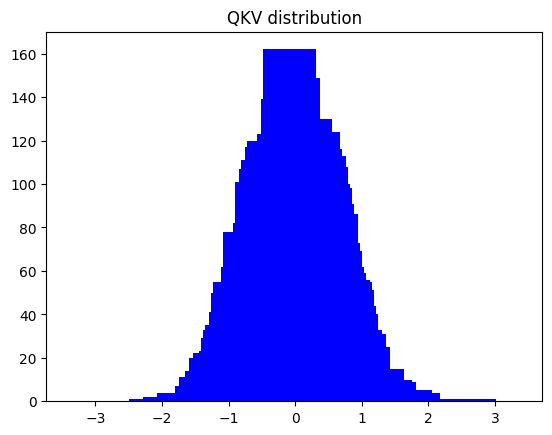

In [7]:
import matplotlib.pyplot as plt
x = np.arange(-1,1,0.01)*3
y = torch.histc(QKV, bins=200, min=-3, max=3)
plt.bar(x,y,align='center',color=['blue'])
plt.title("QKV distribution")

Now we are taking `num_head = 8`, hence we'll reshape the QKV matrix accordingly. The head dimensions will be the d_model by the num_heads, hence we can shape it according to number of heads (to divide the data in the multiple heads) and 3 * the head dimensions to get Q, K and V

In [8]:
num_heads = 8
head_dim = d_model // num_heads
QKV = QKV.reshape(batch_size, seq_len, num_heads, 3*head_dim)

In [10]:
QKV.shape

torch.Size([1, 4, 8, 192])

Changing the dimensions from `seq_len, num_heads` to `num_heads, seq_len` for the ease of processing on the last two dimensions

In [11]:
QKV = QKV.permute(0,2,1,3)
QKV.shape

torch.Size([1, 8, 4, 192])

In [13]:
Q, K, V = QKV.chunk(3, dim=-1) # Breaking by last dimension hence dim=-1
Q.shape, K.shape, V.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Implementing Self Attention for Multiple Heads

For a single head:

$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$

In [14]:
d_k = Q.size()[-1]
stabilized = torch.matmul(Q, K.transpose(-2, -1))/ np.sqrt(d_k)
stabilized.shape

torch.Size([1, 8, 4, 4])

### MAsking

We'll mask the data so as the decoder doesn't cheat in decoding.

In [15]:
mask = torch.full(stabilized.shape, float('-inf'))
mask = torch.triu(mask, diagonal=1)  # Used for creating triangular matrix

In [17]:
mask[0][0] # Mask for a input for single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [19]:
(stabilized+mask)[0][0]

tensor([[ 0.3259,    -inf,    -inf,    -inf],
        [ 0.4438,  0.2990,    -inf,    -inf],
        [-0.0922,  0.6536,  0.3198,    -inf],
        [ 0.1699,  0.1053, -0.3614, -0.2198]], grad_fn=<SelectBackward0>)

In [20]:
stabilized += mask

Now we perform the softmax operation to convert the data into probability distribution, (as e^(-inf) = 0), hence the decoder wont be able to take it's context)

We have a builtin Softmax function from Torch's neural networks, and its implemented the same way as we have done above.

In [24]:
attention = F.softmax(stabilized, dim=-1)

In [25]:
attention.shape

torch.Size([1, 8, 4, 4])

In [26]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5361, 0.4639, 0.0000, 0.0000],
        [0.2165, 0.4565, 0.3270, 0.0000],
        [0.3123, 0.2927, 0.1836, 0.2115]], grad_fn=<SelectBackward0>)

## Now we generate new Val vector as above

In [27]:
newVal = torch.matmul(attention, V)
newVal.shape

torch.Size([1, 8, 4, 64])

So if the Q, K, V matrices are given, then the function we have here is as given below:

In [28]:
def multihead_attention(Q, K, V, mask = None):
    d_k = Q.shape[-1]
    stabilized = torch.matmul(Q, K.transpose(-2, -1))/ np.sqrt(d_k)
    if mask is not None:
        stabilized = stabilized+mask
    attention = F.softmax(stabilized, dim=-1)
    Output = torch.matmul(attention, V)
    return Output

In [31]:
out = multihead_attention(Q, K, V, mask= None)
out

tensor([[[[ 1.4978e-02,  2.3663e-01,  1.6114e-01,  ..., -6.9181e-01,
            5.7441e-01,  6.5830e-02],
          [-2.1464e-02,  2.8223e-01,  1.7461e-01,  ..., -6.5455e-01,
            6.2107e-01,  3.3795e-02],
          [-1.8537e-01,  2.5994e-01,  2.3923e-01,  ..., -7.2543e-01,
            7.4261e-01,  1.8783e-01],
          [ 5.2140e-04,  2.6070e-01,  1.7505e-01,  ..., -6.3518e-01,
            6.0713e-01,  4.7038e-02]],

         [[ 1.8249e-01, -4.5593e-01,  4.2315e-02,  ..., -1.7035e-01,
           -3.6548e-01, -4.2218e-01],
          [ 1.3278e-01, -3.2880e-01, -1.1906e-02,  ..., -1.9151e-01,
           -4.2904e-01, -4.1078e-01],
          [ 2.8622e-01, -5.4838e-01, -7.7616e-03,  ..., -3.2329e-01,
           -2.8535e-01, -5.9498e-01],
          [ 1.8461e-01, -7.2107e-01,  1.6522e-01,  ..., -1.4510e-01,
           -3.8200e-01, -1.2629e-01]],

         [[-1.0624e-01, -1.0433e-01,  3.6652e-02,  ..., -9.5584e-02,
            3.9210e-01,  4.3972e-01],
          [-2.6631e-01, -8.8138e-

In [32]:
out = multihead_attention(Q, K, V, mask)
out

tensor([[[[ 6.4529e-01,  3.1930e-01, -1.3173e-01,  ..., -6.0471e-01,
            4.4914e-02, -5.3154e-01],
          [ 1.7461e-01,  1.0009e-01,  2.4083e-02,  ..., -1.1043e+00,
            2.8910e-01,  1.0770e-01],
          [-2.6310e-01,  2.4970e-01,  2.2142e-01,  ..., -9.5741e-01,
            7.3394e-01,  2.5061e-01],
          [ 5.2140e-04,  2.6070e-01,  1.7505e-01,  ..., -6.3518e-01,
            6.0713e-01,  4.7038e-02]],

         [[ 7.3822e-01, -1.0076e+00, -9.0070e-02,  ..., -7.4522e-01,
            1.4601e-01, -1.3474e+00],
          [ 3.9463e-01, -7.0996e-01,  1.0327e-01,  ..., -1.8662e-01,
           -1.0153e-01, -7.7890e-01],
          [ 3.2883e-01, -3.5622e-01, -1.2717e-01,  ..., -3.9021e-01,
           -2.2907e-01, -9.3328e-01],
          [ 1.8461e-01, -7.2107e-01,  1.6522e-01,  ..., -1.4510e-01,
           -3.8200e-01, -1.2629e-01]],

         [[-7.8245e-01,  1.3699e-01,  1.3189e-01,  ...,  2.8067e-01,
            1.4551e-01,  4.9573e-01],
          [-1.0694e-01,  1.2857e-

## Combining the results of all the heads and making it same as input dimension

In [33]:
out = out.reshape(batch_size, seq_len, num_heads*head_dim)
out.shape

torch.Size([1, 4, 512])

to share the results of the patterns by these heads, we'll use a linear model so the heads can communicate.

In [34]:
LL = nn.Linear(d_model, d_model)

In [35]:
out = LL(out)

In [36]:
out.shape

torch.Size([1, 4, 512])

Now the output we have is very much context aware, we can improve this whole structure by implementing Multihead Attention as a class.

In [37]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, input_dim: int):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.input_dim = input_dim
        self.head_dim = d_model // num_heads
        self.QKV_layer = nn.Linear(input_dim, 3*d_model)
        self.LinearLayer = nn.Linear(d_model, d_model)

    def forward(self, data, mask=None):
        batch_size, seq_len, input_dim = data.size()
        print(f"data.size()= {data.size()}")
        QKV = self.QKV_layer(data)
        print(f"QKV.siz()= {QKV.size()}")
        QKV = QKV.reshape(batch_size, seq_len, self.num_heads, 3*self.head_dim)
        print(f"QKV.siz()= {QKV.size()}")
        QKV = QKV.permute(0,2,1,3)
        print(f"QKV.siz()= {QKV.size()}")
        Q, K, V = QKV.chunk(3, dim=-1)
        print(f"Q.size()= {Q.size()}, K.size()= {K.size()}, V.size()= {V.size()}")
        newVal = multihead_attention(Q, K, V, mask)
        print(f"newVal.size()= {newVal.size()}")
        newVal = newVal.reshape(batch_size, seq_len, self.num_heads*self.head_dim)
        print(f"newVal.size()= {newVal.size()}")
        Output = self.LinearLayer(newVal)
        print(f"Output.size()= {Output.size()}")
        return Output

Sample input for the crosscheck of its functioning

In [38]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 20
seq_len = 6
X = torch.randn((batch_size, seq_len, input_dim))

model = MultiHeadAttention(d_model, num_heads, input_dim)
output = model.forward(X)

data.size()= torch.Size([20, 6, 1024])
QKV.siz()= torch.Size([20, 6, 1536])
QKV.siz()= torch.Size([20, 6, 8, 192])
QKV.siz()= torch.Size([20, 8, 6, 192])
Q.size()= torch.Size([20, 8, 6, 64]), K.size()= torch.Size([20, 8, 6, 64]), V.size()= torch.Size([20, 8, 6, 64])
newVal.size()= torch.Size([20, 8, 6, 64])
newVal.size()= torch.Size([20, 6, 512])
Output.size()= torch.Size([20, 6, 512])


## Implementation of Positional Encoding phase

In [1]:
import torch
from torch import nn
max_sequence = 10
d_model = 6

In [2]:
even_i = torch.arange(0, d_model, 2).float()

In [3]:
even_i

tensor([0., 2., 4.])

In [6]:
even_denominator = torch.pow(10000, even_i/d_model)
even_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [7]:
odd_i = torch.arange(1, d_model, 2).float()
odd_i

tensor([1., 3., 5.])

In [9]:
odd_denominator = torch.pow(10000, (odd_i-1)/d_model)
odd_denominator

tensor([  1.0000,  21.5443, 464.1590])

Since the denominators are same for both of them, we'll use any one as our denominator

In [10]:
denominator = even_denominator

In [12]:
position = torch.arange(max_sequence, dtype=torch.float).reshape(max_sequence, 1)

In [13]:
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [14]:
even_pe = torch.sin(position/denominator)
odd_pe = torch.cos(position/denominator)

In [15]:
even_pe

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])

In [16]:
stacked = torch.stack([even_pe, odd_pe], dim=2)
stacked.shape, stacked

(torch.Size([10, 3, 2]),
 tensor([[[ 0.0000,  1.0000],
          [ 0.0000,  1.0000],
          [ 0.0000,  1.0000]],
 
         [[ 0.8415,  0.5403],
          [ 0.0464,  0.9989],
          [ 0.0022,  1.0000]],
 
         [[ 0.9093, -0.4161],
          [ 0.0927,  0.9957],
          [ 0.0043,  1.0000]],
 
         [[ 0.1411, -0.9900],
          [ 0.1388,  0.9903],
          [ 0.0065,  1.0000]],
 
         [[-0.7568, -0.6536],
          [ 0.1846,  0.9828],
          [ 0.0086,  1.0000]],
 
         [[-0.9589,  0.2837],
          [ 0.2300,  0.9732],
          [ 0.0108,  0.9999]],
 
         [[-0.2794,  0.9602],
          [ 0.2749,  0.9615],
          [ 0.0129,  0.9999]],
 
         [[ 0.6570,  0.7539],
          [ 0.3192,  0.9477],
          [ 0.0151,  0.9999]],
 
         [[ 0.9894, -0.1455],
          [ 0.3629,  0.9318],
          [ 0.0172,  0.9999]],
 
         [[ 0.4121, -0.9111],
          [ 0.4057,  0.9140],
          [ 0.0194,  0.9998]]]))

In [17]:
PE = torch.flatten(stacked, start_dim=1, end_dim=2)
PE

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

## Positional Encoding Implementation as Class

In [18]:
import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_pe = torch.sin(position/denominator)
        odd_pe = torch.cos(position/denominator)
        stacked = torch.stack([even_pe, odd_pe], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

In [19]:
pe = PositionalEncoding(d_model = 6, max_sequence_length = 10)
PE = pe.forward()
PE.shape

torch.Size([10, 6])

In [20]:
PE

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

## Layer Normalization

It is a technique to convert the data into normalized form, this step comes after Multihead Attention and it takes the output of Multihead Attention as well as the Positional Encoding vector as input. We make the data such that the mena is close or equal to 0 and standard deviation is close to 1.

In [1]:
import torch
from torch import nn

In [2]:
inputs = torch.Tensor([[[0.2,0.1,0.3], [0.5,0.1,0.1]]])
B, S, E = inputs.size()
inputs = inputs.reshape(S, B, E)
inputs.size(), inputs

(torch.Size([2, 1, 3]),
 tensor([[[0.2000, 0.1000, 0.3000]],
 
         [[0.5000, 0.1000, 0.1000]]]))

In [3]:
parameter_shape =inputs.size()[-2:]
gamma = nn.Parameter(torch.ones(parameter_shape))
beta = nn.Parameter(torch.zeros(parameter_shape))

In [4]:
gamma.size(), beta.size()

(torch.Size([1, 3]), torch.Size([1, 3]))

In [5]:
dims = [-(i+1) for i in range(len(parameter_shape))]

In [6]:
mean = inputs.mean(dim = dims, keepdim = True)
mean.size(), mean

(torch.Size([2, 1, 1]),
 tensor([[[0.2000]],
 
         [[0.2333]]]))

In [7]:
variance = ((inputs-mean)**2).mean(dim = dims, keepdim = True)
epsilon = 1e-5
std = (variance+epsilon).sqrt()
std

tensor([[[0.0817]],

        [[0.1886]]])

In [8]:
 y = (inputs-mean)/std
 y

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]])

Now the data is normalized

In [9]:
out = gamma*y + beta
out

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]], grad_fn=<AddBackward0>)

This additional variable we have here `grad_fn=<AddBackward0>` is a learnable parameter which updates Beta nd Gamma during back propagation phase

Implementing it as as class

In [10]:
class LayerNormalization():
    def __init__(self, parameters_shape, epsilon=1e-5):
        self.parameters_shape = parameters_shape
        self.epsilon = epsilon
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta = nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, input):
        dims = [-(i+1) for i in range(len(self.parameters_shape))]
        mean = input.mean(dims, keepdim = True)
        print(f"mean.size()= {mean.size()}\n mean= {mean}")
        var = ((inputs-mean)**2).mean(dim=dims, keepdim = True)
        std = (var+self.epsilon).sqrt()
        print(f"Standard Deviation, size= {std.size()}\n std= {std}")
        y = (input-mean)/std
        print(f"y.size()= {y.size()}\n y= {y}")
        out = self.gamma*y + self.beta
        print(f"out.size()= {out.size()}\n out= {out}")
        return out

Testing the implementation

In [12]:
batch_size = 3
sentence_length = 5
embedding_dim = 8
inputs = torch.randn(sentence_length, batch_size, embedding_dim)
print(inputs.size)
print(inputs)

<built-in method size of Tensor object at 0x00000207BD9A4170>
tensor([[[-0.3961,  0.4453, -0.8466, -0.2637,  0.2882, -0.7683, -1.8714,
          -0.5708],
         [ 0.4236,  0.7944, -0.3965,  2.0837,  1.5313, -0.2555, -0.5523,
           0.2299],
         [-0.2144, -2.1346, -1.1441,  0.1578,  1.0576, -0.3471, -0.7582,
          -0.6512]],

        [[-2.1511,  0.2545, -0.3785, -0.8013, -2.2646, -0.7982,  0.1091,
          -0.0393],
         [ 1.2741,  0.0379,  1.8489,  0.5550, -0.9414, -0.5049, -2.2548,
           2.4859],
         [-0.9429, -1.4084, -2.9085, -0.2017,  0.5564, -0.3930,  0.8198,
          -0.7483]],

        [[-1.8498,  0.5723,  2.2822, -0.0952,  0.6893,  0.2898,  0.4487,
           1.5775],
         [-1.2987,  0.7168, -0.1050,  1.4360,  2.0061, -0.6024, -0.5367,
           1.1440],
         [-0.4555,  1.7813,  0.3584,  1.0669,  0.3544,  0.3956, -0.0149,
           0.6530]],

        [[-1.1172, -0.6415,  0.2045,  0.3716,  0.7389, -0.3432, -0.3856,
          -0.7825],
  

In [13]:
layer_norm_layer = LayerNormalization(inputs.size()[-2:])

In [14]:
out = layer_norm_layer.forward(inputs)

mean.size()= torch.Size([5, 1, 1])
 mean= tensor([[[-0.1733]],

        [[-0.3665]],

        [[ 0.4506]],

        [[ 0.0644]],

        [[ 0.2858]]])
Standard Deviation, size= torch.Size([5, 1, 1])
 std= tensor([[[0.9393]],

        [[1.2724]],

        [[0.9780]],

        [[0.7241]],

        [[1.3807]]])
y.size()= torch.Size([5, 3, 8])
 y= tensor([[[-2.3723e-01,  6.5859e-01, -7.1683e-01, -9.6298e-02,  4.9133e-01,
          -6.3350e-01, -1.8079e+00, -4.2318e-01],
         [ 6.3544e-01,  1.0302e+00, -2.3767e-01,  2.4029e+00,  1.8148e+00,
          -8.7517e-02, -4.0348e-01,  4.2925e-01],
         [-4.3778e-02, -2.0881e+00, -1.0335e+00,  3.5253e-01,  1.3104e+00,
          -1.8501e-01, -6.2266e-01, -5.0881e-01]],

        [[-1.4025e+00,  4.8806e-01, -9.4283e-03, -3.4170e-01, -1.4917e+00,
          -3.3929e-01,  3.7372e-01,  2.5715e-01],
         [ 1.2893e+00,  3.1777e-01,  1.7410e+00,  7.2417e-01, -4.5182e-01,
          -1.0882e-01, -1.4840e+00,  2.2417e+00],
         [-4.5303e-01, -8.